About the data

https://www.kaggle.com/jangot/ligue1-match-statistics/data

Match Statistics from top 5 European Leagues
Italy, Spain, England, Germany, France 2012-2017

by Jemilu Mohammed
last updated 3 months ago

## The Idea

1. For a specific manager, derive the average points gained (ranges from 0 to 3) from each of other managers and the mean statistics of them.
2. Focus on the managers from whom not much points have been gained.
3. See if there is a similarities between these managers.

In [108]:
# imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sys

from scipy import spatial
from sklearn import metrics
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR


In [109]:
# methods
def normalize(df):
    df_norm = df
    df_norm -= df_norm.min()
    df_norm /= df_norm.max() - df_norm.min()
    return df_norm

def filterData(df, managerSurname, homeOrAway):
    if ('home' == homeOrAway):
        return df[df['homeManagerName'].str.contains(managerSurname)]
    elif ('away' == homeOrAway):
        return df[df['awayManagerName'].str.contains(managerSurname)]
    else:
        return df

def populatePoint(goalDiff):
    if (goalDiff > 0):
        return 3
    elif (goalDiff == 0):
        return 1
    else:
        return 0

def computeDistance(stat1, stat2):
    statDistance = spatial.distance.cosine(stat1, stat2) # Calculating distance here
    return statDistance


In [110]:
# input parameters
managerSurname = 'Simeone'
threshold = 3


In [164]:
# read data from csv
fullStatDF = pd.read_csv("data/FootballEurope.csv")
#fullStatDF.dtypes
fullStatDF.head()


C:\devtool\app\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (39,61) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,id,homeTacklesTotalHT,homeShotsTotalHT,awayDispossessedFT,awayPassSuccessFT,awayRatingsFT,awayDribbleSuccessFT,awayDribblesAttemptedHT,awayTeamLineUp,...,homeInterceptionsFT,homePassSuccessHT,date,awayTacklesTotalFT,homeRatingsFT,homeDribblesAttemptedFT,homeTackleSuccessFT,awayPossessionFT,awayShotsTotalFT,division
0,1,1,18,10,14.0,73.69,6.38,47.22,12,"Joel Robles,Paul Scharner,Antolin Alcaraz,Emme...",...,21,69.45,2013-05-14,18,6.73,12.0,75.00,52.35,11.0,EPL
1,2,2,13,3,11.0,75.78,6.39,27.27,5,"Petr Cech,César Azpilicueta,Branislav Ivanovic...",...,14,78.64,2012-11-03,26,6.37,13.0,88.89,46.29,11.0,EPL
2,3,3,10,5,16.0,74.86,6.73,66.67,4,"Anders Lindegaard,Antonio Valencia,Phil Jones,...",...,5,75.31,2013-05-19,20,6.04,11.0,75.00,60.18,15.0,EPL
3,4,4,8,5,6.0,78.43,6.41,27.78,4,"Michel Vorm,Angel Rangel,Garry Monk,Ashley Wil...",...,23,67.21,2013-03-09,23,6.43,14.0,79.55,54.02,11.0,EPL
4,5,5,13,6,9.0,61.07,6.51,40.00,9,"Asmir Begovic,Geoff Cameron,Marc Wilson,Ryan S...",...,7,78.95,2013-03-10,37,6.45,24.0,71.93,46.80,8.0,EPL


In [112]:
# clean data
fullStatDF = fullStatDF.dropna(how='any')
#fullStatDF2 = fullStatDF.copy(deep=True)

In [113]:
# filter data: specific manager, home or away
managerHomeDF = filterData(fullStatDF, managerSurname, 'home')
managerAwayDF = filterData(fullStatDF, managerSurname, 'away')


In [114]:
managerHomeDF['awayGoalFT'] = managerHomeDF['awayGoalFT'].apply(lambda x : int(x))
managerHomeDF['homeGoalFT'] = managerHomeDF['homeGoalFT'].apply(lambda x : int(x))

# homeGoal = managerHomeDF['homeGoalFT'].values.tolist()
# homeGoal = list(homeGoalFT)
# awayGoal = managerHomeDF['awayGoalFT'].values.tolist()
# awayGoal = list(homeGoalFT)
# idx = []
# for i in awayGoal:
#     for _ in i:
#         if type(_) == int:
#             idx.append(awayGoal.index(i))
# print(idx)
# # print(homeGoal)

C:\devtool\app\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\devtool\app\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [115]:
managerHomeDF['goalDiff'] = managerHomeDF['homeGoalFT'] - managerHomeDF['awayGoalFT']
managerHomeDF['points'] = managerHomeDF['goalDiff'].apply(populatePoint)

managerAwayDF['goalDiff'] = managerAwayDF['awayGoalFT'] - managerAwayDF['homeGoalFT']
managerAwayDF['points'] = managerAwayDF['goalDiff'].apply(populatePoint)

#def winLoss(x):
#    if x > 0:
#        return 3
#    if x ==0:
#        return 1
#    else:
#        return 0
#managerHomeDF2['points'] = managerHomeDF2['goalDiff'].apply(winLoss)
#managerHomeDF2.head()

C:\devtool\app\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\devtool\app\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\devtool\app\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.

In [116]:
managerHomeDF.head()

,Unnamed: 0,id,homeTacklesTotalHT,homeShotsTotalHT,awayDispossessedFT,awayPassSuccessFT,awayRatingsFT,awayDribbleSuccessFT,awayDribblesAttemptedHT,awayTeamLineUp,...,date,awayTacklesTotalFT,homeRatingsFT,homeDribblesAttemptedFT,homeTackleSuccessFT,awayPossessionFT,awayShotsTotalFT,division,goalDiff,points
5361,5362,34,11,9,8.0,52.89,6.79,47.06,8,"Claudio Bravo,Carlos Martínez,Iñigo Martínez,M...",...,2013-03-10,29,6.48,16.0,68.94,43.94,10.0,La_Liga,-1,0
5373,5374,46,9,5,13.0,57.64,6.41,23.08,4,"Kiko Casilla,Javi López,Diego Colotto,Héctor M...",...,2013-02-24,54,6.76,34.0,86.96,50.61,12.0,La_Liga,1,3
5410,5411,83,23,9,17.0,69.52,6.63,40.00,14,"Adrián,Javi Chica,Damien Perquis,Antonio Amaya...",...,2013-02-03,31,6.80,22.0,78.79,54.94,6.0,La_Liga,1,3
5430,5431,103,12,5,7.0,57.80,6.67,38.89,8,"Dudu Aouate,Alan Hutton,Geromel,Pedro Bigas,An...",...,2013-05-26,47,6.49,25.0,69.57,42.05,12.0,La_Liga,0,1
5431,5432,104,11,8,11.0,54.35,6.25,19.23,7,"Gustavo Munúa,Christian Lell,Sergio Ballestero...",...,2013-01-20,31,6.72,9.0,90.91,45.28,10.0,La_Liga,2,3


In [117]:
# populate win/loss column
# managerHomeDF['point'] = managerHomeDF['point'.map(populateHomeGamePoint)
#pd.set_option('display.max_rows', 100)
#print(managerHomeDF.dtypes)

In [118]:
# fields interested
fieldsInterestedHome = ['awayManagerName', 'points', 'awayTackleSuccessFT', 'awayPossessionFT', 'awayPassesKeyFT', 'awayPassSuccessFT', 'awayCornersTotalFT', 'awayAerialsTotalFT', 'awayDribblesWonFT', 'awayDispossessedFT', 'awayOffsidesCaughtFT', 'awayInterceptionsFT', 'awayFoulsCommitedFT']
fieldsInterestedAway = ['homeManagerName', 'points', 'homeTackleSuccessFT', 'homePossessionFT', 'homePassesKeyFT', 'homePassSuccessFT', 'homeCornersTotalFT', 'homeAerialsTotalFT', 'homeDribblesWonFT', 'homeDispossessedFT', 'homeOffsidesCaughtFT', 'homeInterceptionsFT', 'homeFoulsCommitedFT']

# columns to apply feature scaling
scaleColumnsHome = ['points', 'awayTackleSuccessFT', 'awayPossessionFT', 'awayPassesKeyFT', 'awayPassSuccessFT', 'awayCornersTotalFT', 'awayAerialsTotalFT', 'awayDribblesWonFT', 'awayDispossessedFT', 'awayOffsidesCaughtFT', 'awayInterceptionsFT', 'awayFoulsCommitedFT']
scaleColumnsAway = ['points', 'homeTackleSuccessFT', 'homePossessionFT', 'homePassesKeyFT', 'homePassSuccessFT', 'homeCornersTotalFT', 'homeAerialsTotalFT', 'homeDribblesWonFT', 'homeDispossessedFT', 'homeOffsidesCaughtFT', 'homeInterceptionsFT', 'homeFoulsCommitedFT']


In [119]:
# narrow down fields
managerHomeDF = managerHomeDF[fieldsInterestedHome]
managerAwayDF = managerAwayDF[fieldsInterestedAway]


In [120]:
managerHomeDF.head()

,awayManagerName,points,awayTackleSuccessFT,awayPossessionFT,awayPassesKeyFT,awayPassSuccessFT,awayCornersTotalFT,awayAerialsTotalFT,awayDribblesWonFT,awayDispossessedFT,awayOffsidesCaughtFT,awayInterceptionsFT,awayFoulsCommitedFT
5361,Philippe Montanier,0,82.61,43.94,6.0,52.89,5.0,42,8.0,8.0,0.0,9,14
5373,Javier Aguirre,3,65.28,50.61,10.0,57.64,4.0,27,3.0,13.0,0.0,24,23
5410,Pepe Mel,3,55.77,54.94,4.0,69.52,4.0,27,11.0,17.0,0.0,25,14
5430,Gregorio Manzano,1,77.78,42.05,5.0,57.80,3.0,30,8.0,7.0,0.0,17,11
5431,Juan Ignacio Martínez,3,86.54,45.28,5.0,54.35,6.0,21,3.0,11.0,0.0,18,14


In [121]:
managerAwayDF.head()

,homeManagerName,points,homeTackleSuccessFT,homePossessionFT,homePassesKeyFT,homePassSuccessFT,homeCornersTotalFT,homeAerialsTotalFT,homeDribblesWonFT,homeDispossessedFT,homeOffsidesCaughtFT,homeInterceptionsFT,homeFoulsCommitedFT
5341,José Luis Mendilibar,3,89.58,58.04,14,63.91,8.0,49,8.0,13,2.0,17,7
5351,Manuel Pellegrini,1,74.21,45.22,6,60.31,3.0,43,4.0,17,1.0,13,16
5384,Miroslav Djukic,3,82.78,53.50,4,64.42,3.0,37,2.0,9,1.0,23,11
5396,Paco Jémez,0,76.52,57.62,7,73.86,2.0,28,8.0,13,2.0,16,17
5420,Marcelo Bielsa,0,68.59,56.54,18,74.41,8.0,27,9.0,8,2.0,12,9


In [122]:
managerHomeGroupedDF = managerHomeDF.groupby('awayManagerName', as_index=False).mean()
managerHomeGroupedDF = managerHomeGroupedDF.sort_values('points', ascending=True)

managerAwayGroupedDF = managerAwayDF.groupby('homeManagerName', as_index=False).mean()
managerAwayGroupedDF = managerAwayGroupedDF.sort_values('points', ascending=True)

In [123]:
managerHomeGroupedDF.head()

,awayManagerName,points,awayTackleSuccessFT,awayPossessionFT,awayPassesKeyFT,awayPassSuccessFT,awayCornersTotalFT,awayAerialsTotalFT,awayDribblesWonFT,awayDispossessedFT,awayOffsidesCaughtFT,awayInterceptionsFT,awayFoulsCommitedFT
48,Zinedine Zidane,0.0,61.11,0.53,8.0,70.53,6.0,28.0,12.0,11.0,2.0,18.0,14.0
23,José Mourinho,0.0,83.65,44.99,4.0,63.50,2.0,39.0,6.0,18.0,1.0,17.0,15.0
39,Philippe Montanier,0.0,82.61,43.94,6.0,52.89,5.0,42.0,8.0,8.0,0.0,9.0,14.0
44,Tito Vilanova,0.0,72.00,56.29,8.0,84.69,2.0,26.0,11.0,9.0,1.0,16.0,11.0
41,Rafael Benítez,1.0,62.07,51.37,7.0,74.72,1.0,33.0,11.0,10.0,0.0,24.0,12.0


In [124]:
managerAwayGroupedDF.head()

,homeManagerName,points,homeTackleSuccessFT,homePossessionFT,homePassesKeyFT,homePassSuccessFT,homeCornersTotalFT,homeAerialsTotalFT,homeDribblesWonFT,homeDispossessedFT,homeOffsidesCaughtFT,homeInterceptionsFT,homeFoulsCommitedFT
38,Marcelo Bielsa,0.0,68.59,56.54,18.0,74.41,8.0,27.0,9.0,8.0,2.0,12.0,9.0
1,Abelardo Fernández,0.0,75.86,60.56,9.0,69.47,7.0,44.0,6.0,13.0,0.0,17.0,14.0
27,José Mourinho,0.0,94.64,61.33,9.0,70.21,3.0,29.0,9.0,11.0,1.0,15.0,19.0
4,Asier Santana,0.0,71.15,52.45,6.0,67.31,2.0,36.0,11.0,12.0,0.0,11.0,17.0
24,Jorge Sampaoli,0.0,70.00,0.59,9.0,71.47,4.0,30.0,14.0,10.0,1.0,20.0,15.0


In [125]:
#print(managerHomeDFGroup.columns)
managerHomeGroupedScaledDF = normalize(managerHomeGroupedDF[scaleColumnsHome])
#managerHomeGroupedScaledDF.insert(0, 'points', managerHomeGroupedDF[['points']])
managerHomeGroupedScaledDF.insert(0, 'awayManagerName', managerHomeGroupedDF[['awayManagerName']])

managerAwayGroupedScaledDF = normalize(managerAwayGroupedDF[scaleColumnsAway])
#managerAwayGroupedScaledDF.insert(0, 'points', managerAwayGroupedDF[['points']])
managerAwayGroupedScaledDF.insert(0, 'homeManagerName', managerAwayGroupedDF[['homeManagerName']])


In [126]:
managerHomeGroupedScaledDF.head()

,awayManagerName,points,awayTackleSuccessFT,awayPossessionFT,awayPassesKeyFT,awayPassSuccessFT,awayCornersTotalFT,awayAerialsTotalFT,awayDribblesWonFT,awayDispossessedFT,awayOffsidesCaughtFT,awayInterceptionsFT,awayFoulsCommitedFT
48,Zinedine Zidane,0.000000,0.188333,0.000000,0.888889,0.625099,0.6,0.236842,0.7500,0.307692,0.666667,0.416667,0.413793
23,José Mourinho,0.000000,1.000000,0.704373,0.296296,0.438973,0.2,0.526316,0.3750,0.576923,0.333333,0.375000,0.482759
39,Philippe Montanier,0.000000,0.962550,0.687738,0.592593,0.158062,0.5,0.605263,0.5000,0.192308,0.000000,0.041667,0.413793
44,Tito Vilanova,0.000000,0.580483,0.883397,0.888889,1.000000,0.2,0.184211,0.6875,0.230769,0.333333,0.333333,0.206897
41,Rafael Benítez,0.333333,0.222902,0.805450,0.740741,0.736034,0.1,0.368421,0.6875,0.269231,0.000000,0.666667,0.275862


In [127]:
managerHomeGroupedScaledDF.shape

(49, 13)

In [128]:
managerAwayGroupedScaledDF.head()

,homeManagerName,points,homeTackleSuccessFT,homePossessionFT,homePassesKeyFT,homePassSuccessFT,homeCornersTotalFT,homeAerialsTotalFT,homeDribblesWonFT,homeDispossessedFT,homeOffsidesCaughtFT,homeInterceptionsFT,homeFoulsCommitedFT
38,Marcelo Bielsa,0.0,0.475222,0.781254,1.0,0.709091,0.8,0.235294,0.428571,0.052632,0.50,0.192308,0.076923
1,Abelardo Fernández,0.0,0.621676,0.837158,0.4,0.600876,0.7,0.568627,0.257143,0.315789,0.00,0.384615,0.269231
27,José Mourinho,0.0,1.000000,0.847865,0.4,0.617087,0.3,0.274510,0.428571,0.210526,0.25,0.307692,0.461538
4,Asier Santana,0.0,0.526793,0.724378,0.2,0.553560,0.2,0.411765,0.542857,0.263158,0.00,0.153846,0.384615
24,Jorge Sampaoli,0.0,0.503626,0.003198,0.4,0.644688,0.4,0.294118,0.714286,0.157895,0.25,0.500000,0.307692


In [129]:
managerAwayGroupedScaledDF.shape

(52, 13)

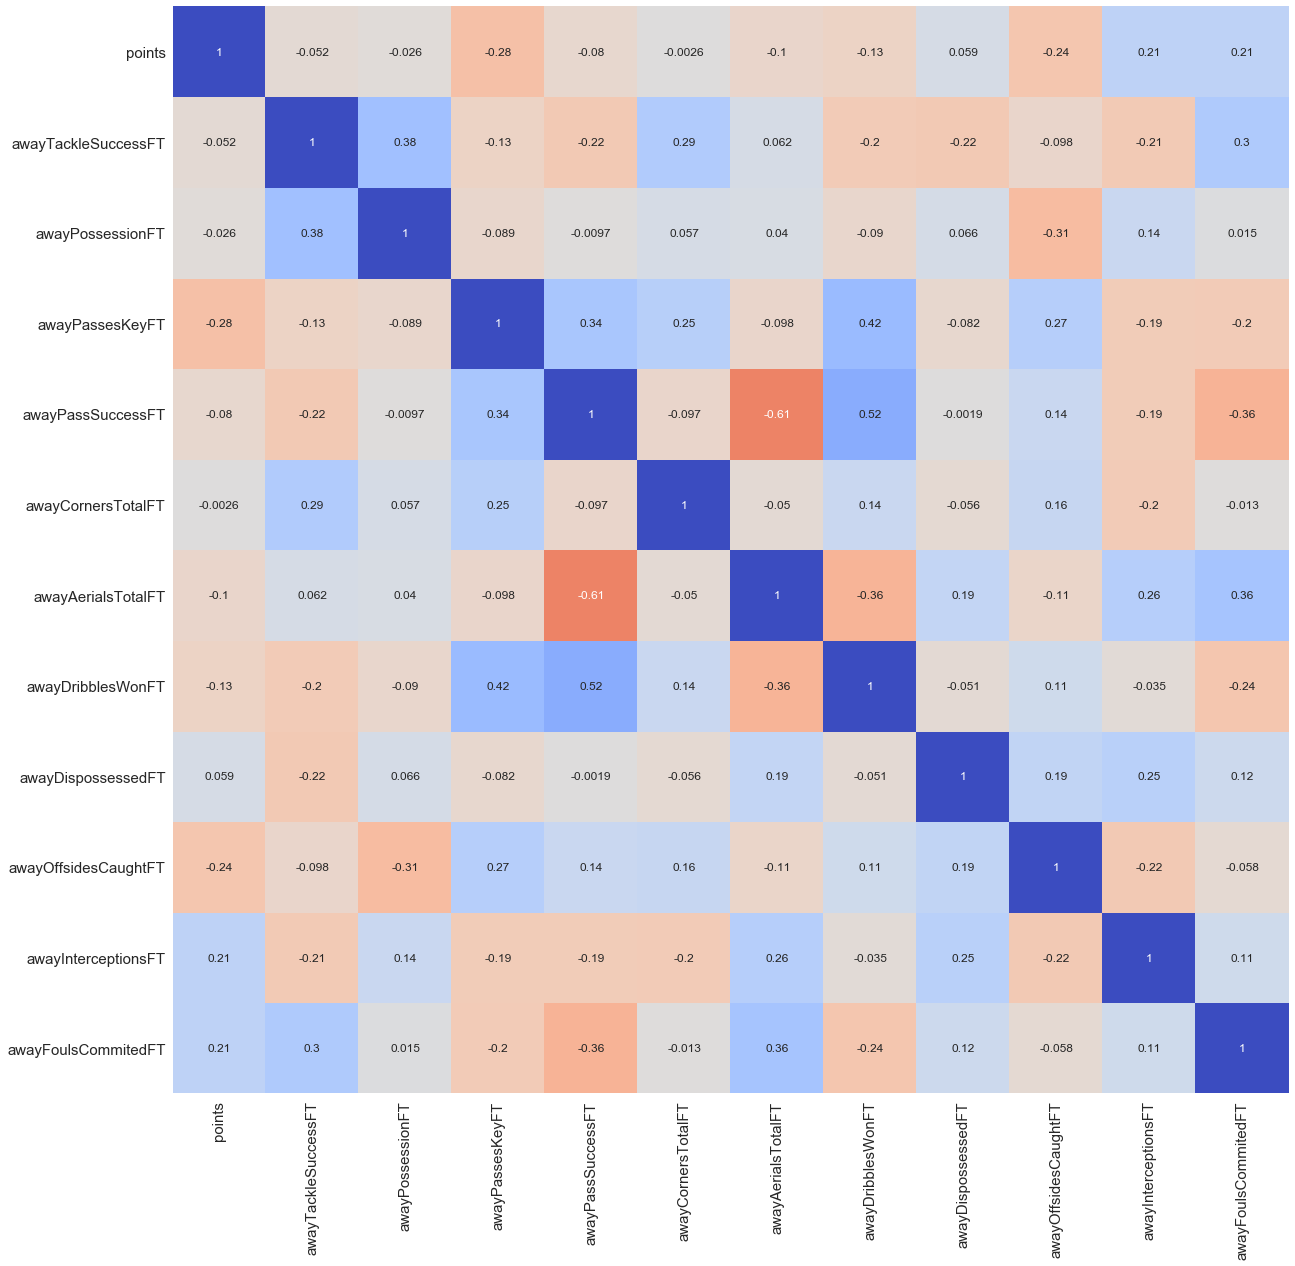

In [130]:
# Correlation Map: points gained VS opponents' statistics
correlations_map=managerHomeGroupedScaledDF.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(correlations_map,annot=True,cbar=False,cmap="coolwarm_r")
plt.xticks(rotation=90,fontsize=15)
plt.yticks(rotation=0,fontsize=15)
plt.show()


In [131]:
# Build Data Frame with points lower than threshold
managerHomeGroupedScaledBelowThresholdDF = managerHomeGroupedScaledDF[managerHomeGroupedScaledDF['points'] <= threshold]
managerHomeGroupedScaledBelowThresholdDF.shape

(49, 13)

In [132]:
managerAwayGroupedScaledBelowThresholdDF = managerAwayGroupedScaledDF[managerAwayGroupedScaledDF['points'] <= threshold]
managerAwayGroupedScaledBelowThresholdDF.shape

(52, 13)

In [152]:
# refine the interested fields list
fieldsInterestedHome = ['awayTackleSuccessFT', 'awayPassesKeyFT', 'awayPassSuccessFT', 'awayAerialsTotalFT', 'awayInterceptionsFT']
fieldsInterestedAway = ['homeTackleSuccessFT', 'homePassesKeyFT', 'homePassSuccessFT', 'homeAerialsTotalFT', 'homeInterceptionsFT']

#fieldsInterestedHome = ['awayAerialsTotalFT', 'awayPassSuccessFT', 'awayInterceptionsFT']
#fieldsInterestedAway = ['homeAerialsTotalFT', 'homePassSuccessFT', 'awayInterceptionsFT']

#fieldsInterestedHome = ['awayPassesKeyFT', 'awayOffsidesCaughtFT', 'awayInterceptionsFT', 'awayFoulsCommitedFT']
#fieldsInterestedAway = ['homePassesKeyFT', 'homeOffsidesCaughtFT', 'homeInterceptionsFT', 'homeFoulsCommitedFT']


In [162]:
# (Home games) for opponents under issue, calculate Distances between each record pair
def buildSimilarityRecordForHomeGame(referenceRecord, df):
    similarityRecord = []
    for i in range(len(df)):
        statDistance = computeDistance(tempReferenceRecord[fieldsInterestedHome].values.tolist(), df.iloc[i][fieldsInterestedHome].values.tolist())
        similarityRecord.append([str(i) + ' ' + df.iloc[i]['awayManagerName'], df.iloc[i]['points'], statDistance])
    return similarityRecord


Reference Manager:  Philippe Montanier


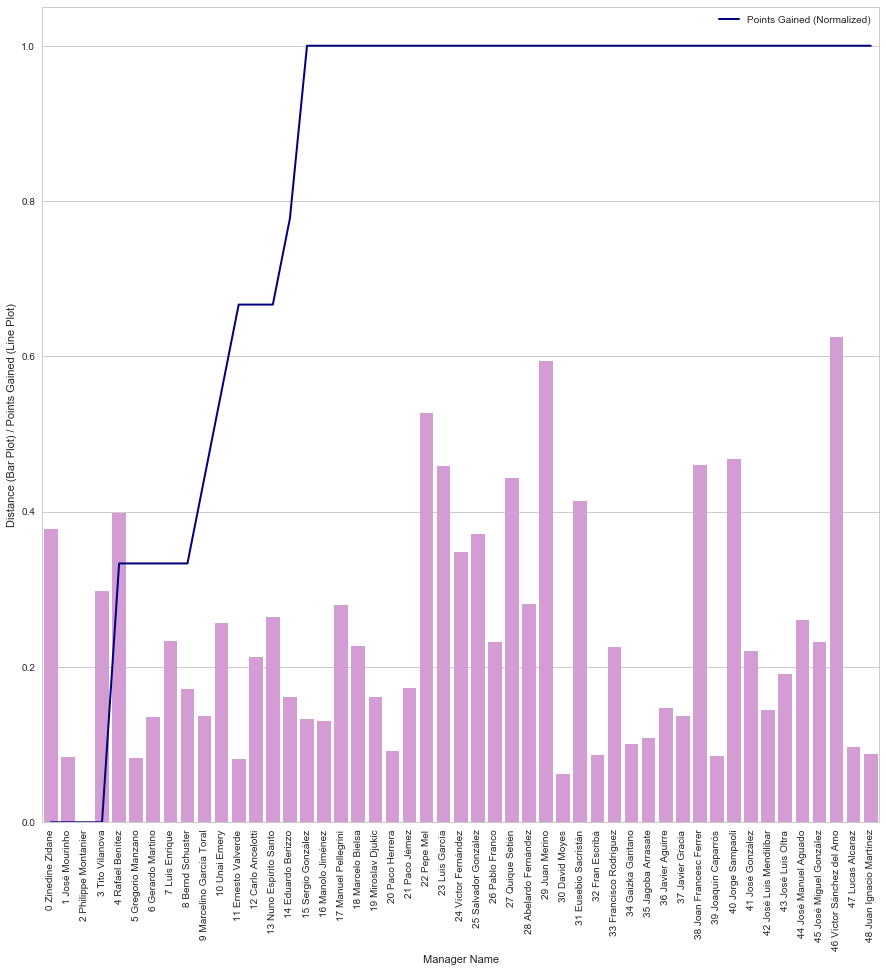

In [163]:
#tempReferenceRecord = managerHomeGroupedScaledBelowThresholdDF.iloc[0]
#tempReferenceRecord = managerHomeGroupedScaledBelowThresholdDF.iloc[15]
tempReferenceRecord = managerHomeGroupedScaledBelowThresholdDF.iloc[2]
print('Reference Manager: ', tempReferenceRecord['awayManagerName'])

managerHomeOpponentSimilarityRecord = buildSimilarityRecordForHomeGame(tempReferenceRecord, managerHomeGroupedScaledBelowThresholdDF)
#print(managerHomeOpponentSimilarityRecord)
fig = plt.figure(figsize=(15,15))

sns.set_style("whitegrid")

plot1 = sns.barplot(x=[row[0] for row in managerHomeOpponentSimilarityRecord], y=[row[2] for row in managerHomeOpponentSimilarityRecord], color="violet", saturation=.5)
plt.plot(range(len(managerHomeOpponentSimilarityRecord)), [row[1] for row in managerHomeOpponentSimilarityRecord], color='navy', lw=2, label="Points Gained (Normalized)")

for item in plot1.get_xticklabels():
    item.set_rotation(90)

plt.xlabel('Manager Name')
plt.ylabel('Distance (Bar Plot) / Points Gained (Line Plot)')
#plt.title('Support Vector Regression')
plt.legend()
plt.show()
#print([row[0] for row in managerHomeOpponentSimilarityRecord])

In [149]:
# (Away games) for opponents under issue, calculate Distances between each record pair


#tempReferenceRecord = managerAwayGroupedScaledBelowThresholdDF.iloc[2]
#tempReferenceRecord = managerAwayGroupedScaledBelowThresholdDF.iloc[0]
tempReferenceRecord = managerAwayGroupedScaledBelowThresholdDF.iloc[7]
print('Reference Manager: ', tempReferenceRecord['homeManagerName'])

managerAwayOpponentSimilarityRecord = []
for i in range(len(managerAwayGroupedScaledBelowThresholdDF)):
    statDistance = computeDistance(tempReferenceRecord[fieldsInterestedAway].values.tolist(), managerAwayGroupedScaledBelowThresholdDF.iloc[i][fieldsInterestedAway].values.tolist())
    managerAwayOpponentSimilarityRecord.append([managerAwayGroupedScaledBelowThresholdDF.iloc[i]['homeManagerName'], managerAwayGroupedScaledBelowThresholdDF.iloc[i]['points'], statDistance])
    
#print(managerAwayOpponentSimilarityRecord)



Reference Manager:  Javier Aguirre


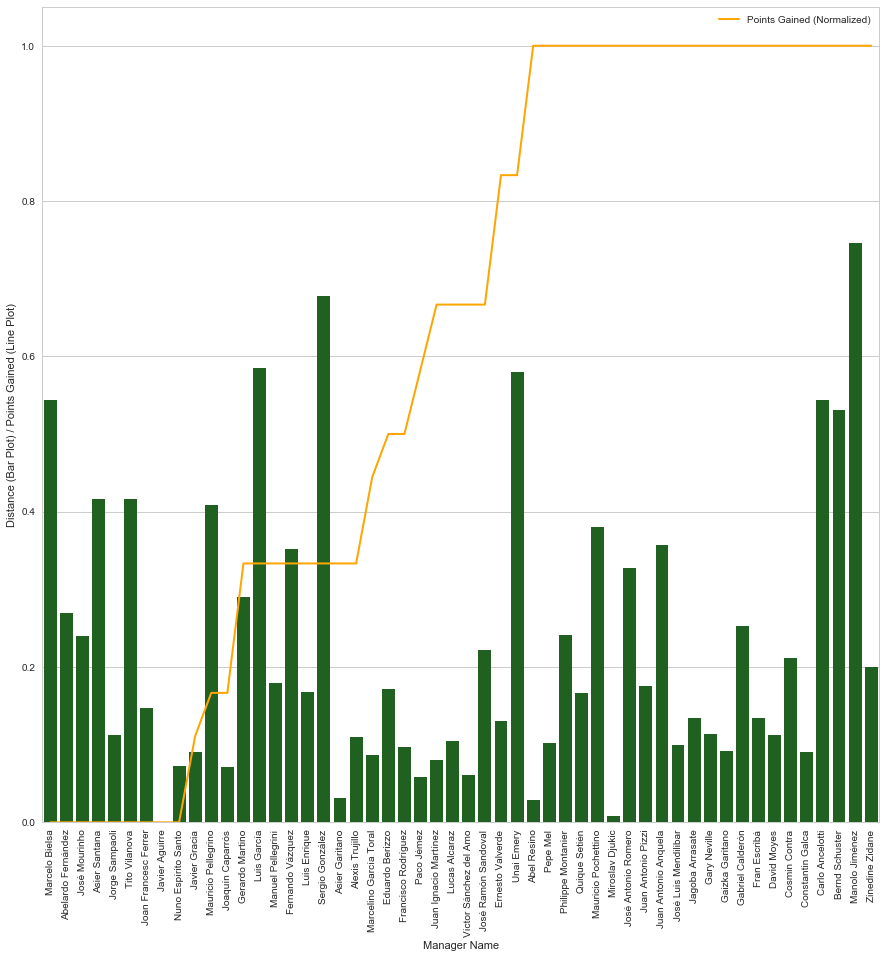

In [141]:
fig = plt.figure(figsize=(15,15))

sns.set_style("whitegrid")

plot1 = sns.barplot(x=[row[0] for row in managerAwayOpponentSimilarityRecord], y=[row[2] for row in managerAwayOpponentSimilarityRecord], color="green", saturation=.5)
plt.plot(range(len(managerAwayOpponentSimilarityRecord)), [row[1] for row in managerAwayOpponentSimilarityRecord], color='orange', lw=2, label="Points Gained (Normalized)")

for item in plot1.get_xticklabels():
    item.set_rotation(90)

plt.xlabel('Manager Name')
plt.ylabel('Distance (Bar Plot) / Points Gained (Line Plot)')
#plt.title('Support Vector Regression')
plt.legend()
plt.show()
#print([row[0] for row in managerHomeOpponentSimilarityRecord])